Testing filtering of stop words in dataset. To do this we can use the python natural language toolkit: https://www.nltk.org/

In [1]:
import nltk
from nltk.corpus import stopwords
import string
import unicodedata
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jikael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jikael/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/jikael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')

In [3]:
df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic pass 2,negative/neutral/positive
0,Biztoc.com,breakingthenews.net,"JD Vance slams Harris: 'Tomorrow, you're fired'",Republican vice presidential candidate JD Vanc...,https://biztoc.com/x/c4c538f75498736e,2024-11-04T22:53:56Z,Vance criticises Harris,Political Attack and Accusations,neutral
1,Biztoc.com,nbcnews.com,'Feels kind of weird': Vance reflects and look...,"Sen. JD Vance, who says running as Trump's VP ...",https://biztoc.com/x/339813fc9b9bc9be,2024-11-04T22:53:24Z,"social fabric, friends, political differences",Social Issues,neutral
2,NBC News,Henry J. Gomez and Alec Hernández,'Feels kind of weird': Vance reflects and look...,'Feels kind of weird': Vance reflects and look...,https://www.nbcnews.com/politics/2024-election...,2024-11-04T22:15:42Z,"social fabric, friends, political differences",Social Issues,neutral
3,Bleeding Cool News,Ray Flook,Last Week Tonight: HBO Releases John Oliver Se...,"For us, Sunday night's edition of HBO's Last W...",https://bleedingcool.com/tv/last-week-tonight-...,2024-11-04T15:07:08Z,"news shows, anti-Vance sentiment",Media and Public Engagement,negative
4,New York Post,Emily Crane,JD Vance says Trump is ‘fired up’ over death o...,Republican vice presidential candidate JD Vanc...,https://nypost.com/2024/11/04/us-news/jd-vance...,2024-11-04T15:06:04Z,"media events, Peanut",Social Issues,neutral


In [4]:
df['publishedAt'].min(), df['publishedAt'].max()

('2024-10-14T02:54:49Z', '2024-11-04T23:32:32Z')

In [5]:
print(df['topic pass 2'].value_counts(normalize=True).to_latex())

\begin{tabular}{lr}
\toprule
 & proportion \\
topic pass 2 &  \\
\midrule
Elections and Political Strategies & 0.213439 \\
Scandals and Controversies & 0.156126 \\
Political Attack and Accusations & 0.154150 \\
Media and Public Engagement & 0.130435 \\
Foreign Policy and National Security & 0.112648 \\
Domestic Policy & 0.100791 \\
Social Issues & 0.090909 \\
Economic and Financial Issues & 0.041502 \\
\bottomrule
\end{tabular}



In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance.tsv', sep='\t')
df['valid'] = df['description'].map(lambda x: type(x) == str)
df=df[df['valid']]
df['topic'] = np.random.randint(0,9, size=len(df))

In [7]:
len(df)

508

In [8]:
df.iloc()[1]['description']

"Sen. JD Vance, who says running as Trump's VP pick has cost him friends, is wrapping up his by asking voters to not let political differences come between them."

In [9]:
from nltk.tokenize import TweetTokenizer # use this one because the other one struggles with words like "don't"

def filter_sentence(sentence, stop_words, tokenizer):
    word_tokens = tokenizer.tokenize(sentence)
    word_tokens = filter(lambda x: len(x) > 1 and x != '...', word_tokens) # removes all punctuation/symbols found by tokenizer
    filtered_sentence = ' '.join([w for w in word_tokens if (not w.lower() in stop_words)]) # remove stop words
    return filtered_sentence

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [11]:
word_tokenize("don't eat that!")

['do', "n't", 'eat', 'that', '!']

In [12]:
TweetTokenizer().tokenize("don't eat that!")

["don't", 'eat', 'that', '!']

In [13]:
def pre_process_descriptions(df):
    stop_words = set(stopwords.words('english'))
    tokenizer = TweetTokenizer()
    df['description_processed'] = df['description'].map(lambda x: filter_sentence(x, stop_words, tokenizer))

In [14]:
pre_process_descriptions(df)

In [15]:
def get_corpus_by_category(df):
  corpus_dict = dict()
  for topic in df.topic.unique():
    filtered_df = df[df.topic == topic]
    sentence = ' '.join(filtered_df['description_processed'])
    corpus_dict[topic] = sentence
  return corpus_dict

In [16]:
corpus = get_corpus_by_category(df)

In [17]:
corpus

{2: "Republican vice presidential candidate JD Vance rallied supporters Atlanta taking aim Vice President Kamala Harris criticized Harris response President Joe Biden recent remarks Republican vice-presidential candidate JD Vance told Joe Rogan surprised Trump wins normal gay guy vote podcast interview controversial comedian JD Vance made number claims including people political rally Aston Pennsylvania Sunday JD Vance told quite whopper Donald Trump Republican presidential nominee believe censorship would suppress Americans free speech know something Donald Trump JD Vance exposes US surveillance state helps China spy Americans Blaze Mediatheblaze.com Sen JD Vance R-OH criticized Vice President Kamala Harris bragging economy United States despite recent data showing 28,000 private sector jobs lost post JD Vance Slams Kamala Harris Bragging Economy Los Nick Arama RedState JD Vance Lights Terrific Interview Joe Rogan Hilarious Moments Kamala JD Vance's three-hour interview Joe Rogan hit 

Now we can perform tf-idf. Note this assumes that we can use the counts of each word rather than frequency.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_tfidf(df, n):
    out_dict = dict()
    vectorizer = CountVectorizer()
    corpus_by_category = get_corpus_by_category(df)
    categories = list(corpus_by_category.keys())
    result = vectorizer.fit_transform(corpus_by_category.values())
    tf = result.toarray()
    feature_names = vectorizer.get_feature_names_out()
    
    N = len(corpus_by_category) # numerator of idf
    document_counts = (tf > 0).sum(axis=0) # denominator of idf
    idf_scores = np.log(N / document_counts) # compute idf scores y
    tf_idf_scores = tf * idf_scores # tf-idf

    for i in range(len(tf)):
        row = tf_idf_scores[i,:]
        indices = np.argsort(row)[::-1][:n]
        words = feature_names
        out_dict[categories[i]] = [[words[i], row[i]] for i in indices]
    
    return out_dict

In [19]:
d = get_top_n_tfidf(df, 10)

In [20]:
d

{2: [['criticized', 6.016309587105097],
  ['broken', 4.394449154672439],
  ['bragging', 4.394449154672439],
  ['employees', 4.394449154672439],
  ['unequivocally', 4.394449154672439],
  ['economy', 4.394449154672439],
  ['lowering', 4.394449154672439],
  ['privately', 4.394449154672439],
  ['gay', 4.394449154672439],
  ['reaction', 4.394449154672439]],
 1: [['slammed', 6.591673732008658],
  ['staff', 4.512232190328822],
  ['wilson', 4.512232190328822],
  ['star', 4.512232190328822],
  ['opted', 4.394449154672439],
  ['harvard', 4.394449154672439],
  ['comedy', 4.394449154672439],
  ['21', 4.394449154672439],
  ['supporter', 4.394449154672439],
  ['valley', 4.394449154672439]],
 5: [['director', 8.788898309344878],
  ['violent', 8.788898309344878],
  ['shapiro', 6.591673732008658],
  ['heritage', 6.016309587105097],
  ['watched', 4.512232190328822],
  ['online', 4.394449154672439],
  ['spread', 4.394449154672439],
  ['focus', 4.394449154672439],
  ['josh', 4.394449154672439],
  ['caring

In [21]:
for v in get_top_n_tfidf(df, 10).values():
    print(v, '\n')

[['criticized', 6.016309587105097], ['broken', 4.394449154672439], ['bragging', 4.394449154672439], ['employees', 4.394449154672439], ['unequivocally', 4.394449154672439], ['economy', 4.394449154672439], ['lowering', 4.394449154672439], ['privately', 4.394449154672439], ['gay', 4.394449154672439], ['reaction', 4.394449154672439]] 

[['slammed', 6.591673732008658], ['staff', 4.512232190328822], ['wilson', 4.512232190328822], ['star', 4.512232190328822], ['opted', 4.394449154672439], ['harvard', 4.394449154672439], ['comedy', 4.394449154672439], ['21', 4.394449154672439], ['supporter', 4.394449154672439], ['valley', 4.394449154672439]] 

[['director', 8.788898309344878], ['violent', 8.788898309344878], ['shapiro', 6.591673732008658], ['heritage', 6.016309587105097], ['watched', 4.512232190328822], ['online', 4.394449154672439], ['spread', 4.394449154672439], ['focus', 4.394449154672439], ['josh', 4.394449154672439], ['caring', 4.394449154672439]] 

[['nato', 6.591673732008658], ['we', 6.

In [22]:
import json
with open('../results/category_tf_idf.json') as f:
    tf_idf_dict = json.load(f)

In [23]:
len(list(tf_idf_dict.keys()))

8

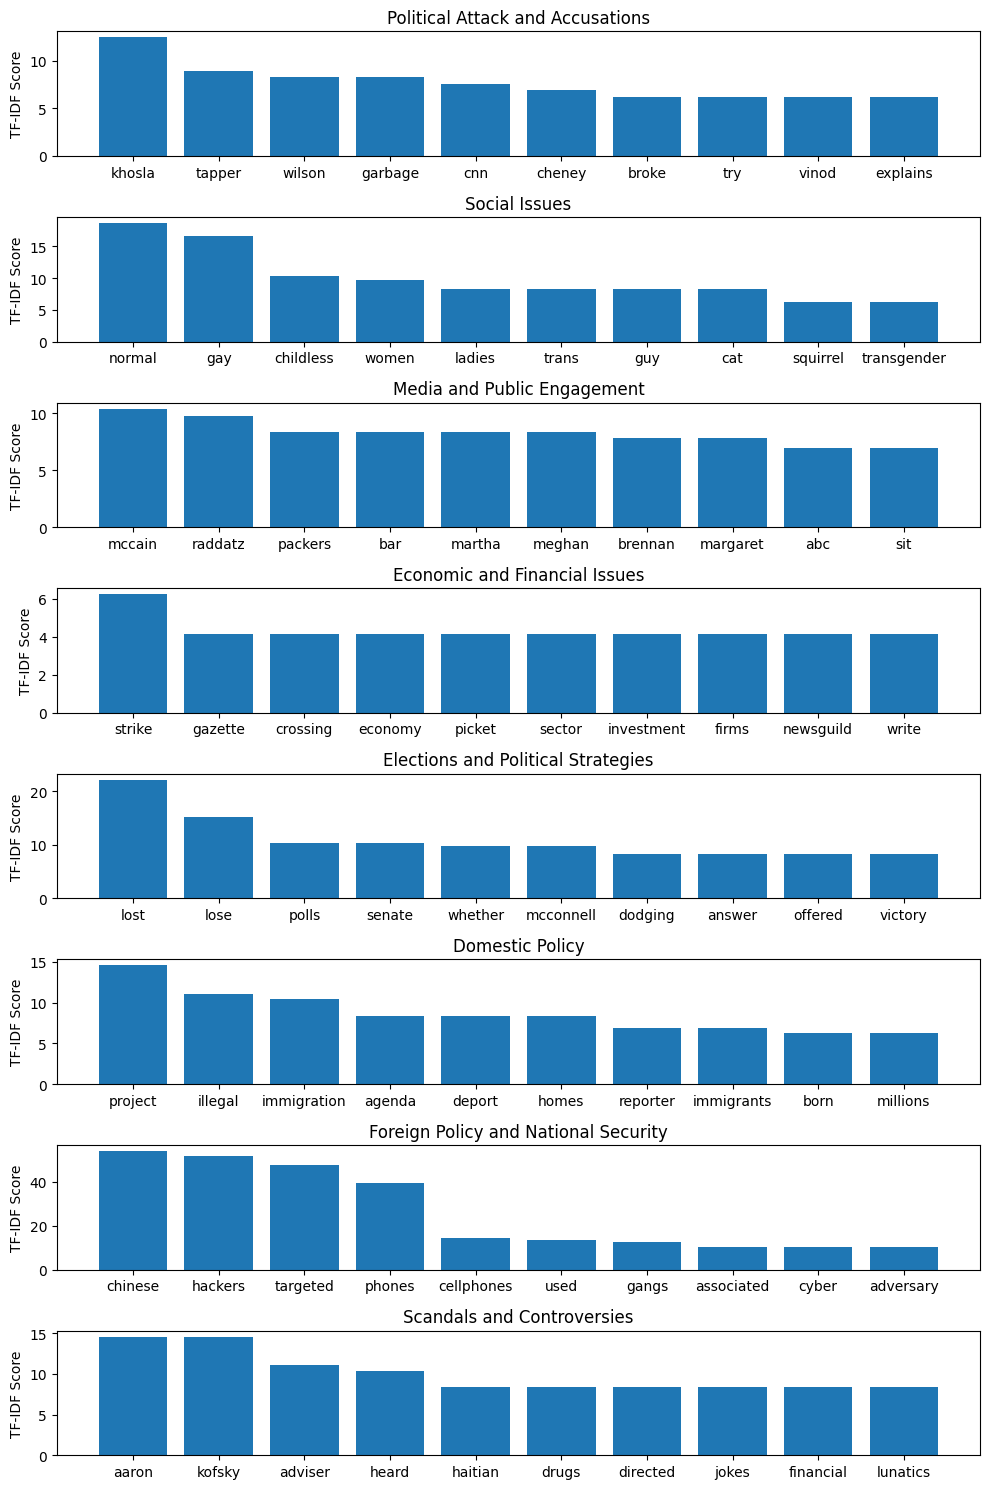

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(8, figsize=(10,15))
# colors = cm.Blues(np.linspace(0.4, 0.9, 10)[::-1])

for i, (category, data) in enumerate(tf_idf_dict.items()):
    words = [e[0] for e in data]
    scores = [e[1] for e in data]
    ax[i].bar(words, scores)
    ax[i].set_title(category)
    ax[i].set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

In [25]:
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')
df = df[df['topic pass 2'].map(lambda x: type(x) == str)]
df['date'] = pd.to_datetime(pd.to_datetime(df['publishedAt']).dt.strftime('%m/%d/%Y'))
df = df.sort_values(by='date')
df['count'] = 1
df['is_negative'] = pd.to_numeric(df['negative/neutral/positive'] == 'negative')
df['is_positive'] = pd.to_numeric(df['negative/neutral/positive'] == 'positive')
df['is_neutral'] = pd.to_numeric(df['negative/neutral/positive'] == 'neutral')

In [26]:
df.groupby('date').sum().reset_index()[['is_negative','is_positive','is_neutral']]


,is_negative,is_positive,is_neutral
0,12,9,17
1,6,1,12
2,14,4,10
3,15,2,27
4,7,3,5
5,1,0,1
6,3,2,1
7,4,2,10
8,2,1,9
9,2,4,10


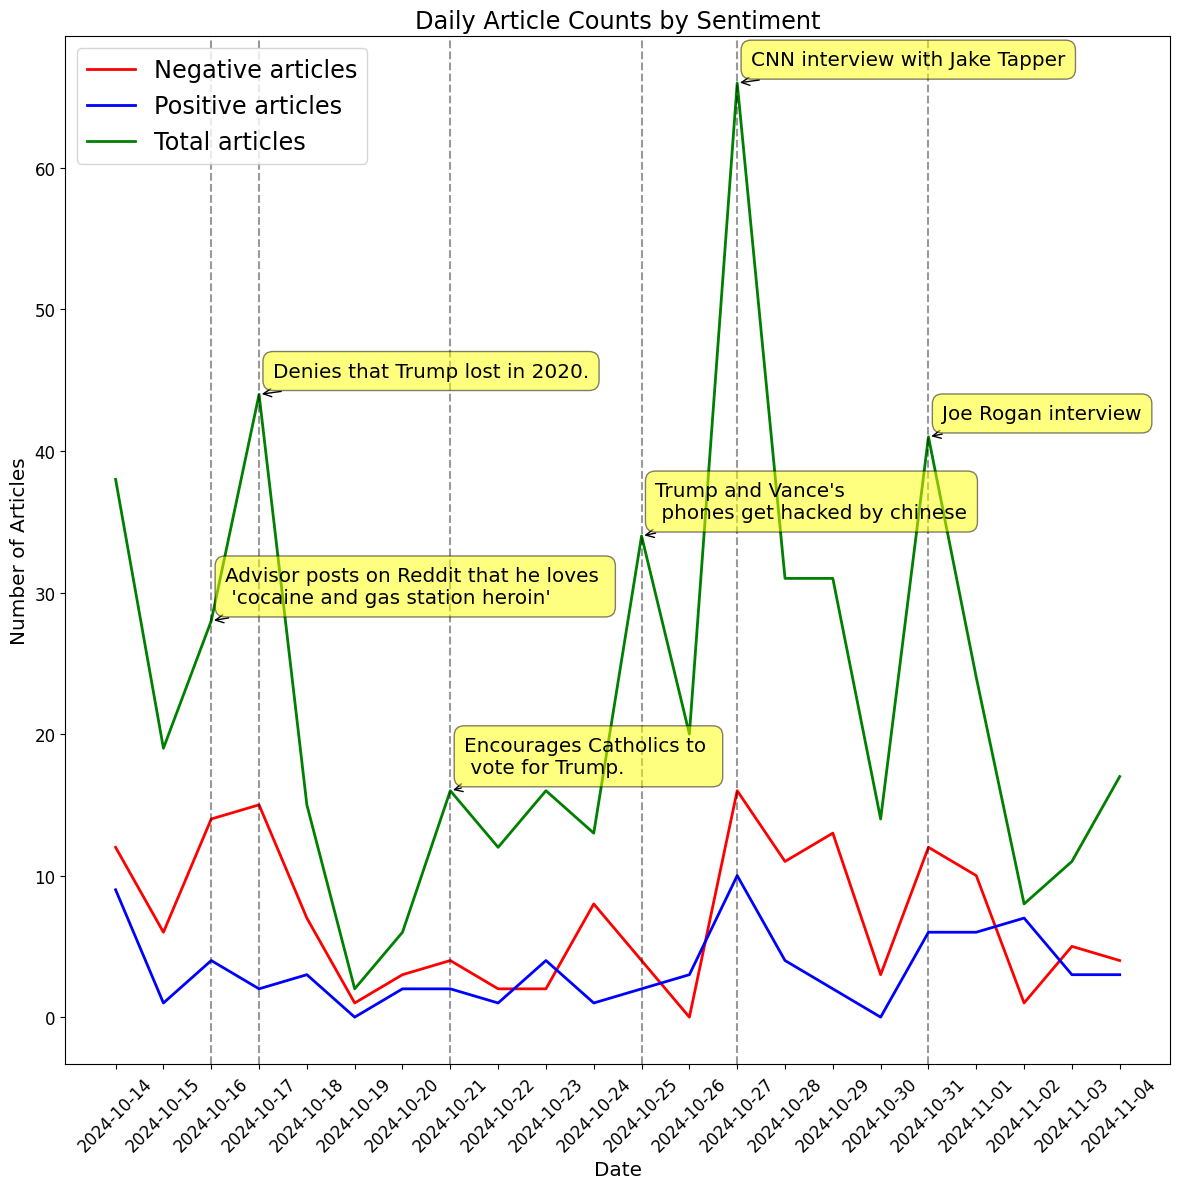

In [27]:
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')
df = df[df['topic pass 2'].map(lambda x: type(x) == str)]
df['date'] = pd.to_datetime(pd.to_datetime(df['publishedAt']).dt.strftime('%m/%d/%Y'))
df = df.sort_values(by='date')
df['count'] = 1
df['is_negative'] = pd.to_numeric(df['negative/neutral/positive'] == 'negative')
df['is_positive'] = pd.to_numeric(df['negative/neutral/positive'] == 'positive')
df['is_neutral'] = pd.to_numeric(df['negative/neutral/positive'] == 'neutral')

window_size = 1

daily_counts = df.groupby('date').sum().reset_index()

daily_counts['total_avg'] = daily_counts['count'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['neg_avg'] = daily_counts['is_negative'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['pos_avg'] = daily_counts['is_positive'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['neut_avg'] = daily_counts['is_neutral'].rolling(window=window_size, center=True, min_periods=1).mean()

import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt

# Assuming you've already created daily_counts with the 3-day moving average
plt.figure(figsize=(12, 12))
plt.plot(daily_counts['date'], daily_counts['neg_avg'], label=f'Negative articles', color='red', linewidth=2)
plt.plot(daily_counts['date'], daily_counts['pos_avg'], label=f'Positive articles', color='blue', linewidth=2)
plt.plot(daily_counts['date'], daily_counts['total_avg'], label=f'Total articles', color='green', linewidth=2)

# Define your special dates
special_events = {
    '2024-10-16': "Advisor posts on Reddit that he loves \n 'cocaine and gas station heroin'",
    '2024-10-17': 'Denies that Trump lost in 2020.',
    '2024-10-21': 'Encourages Catholics to \n vote for Trump.',
    '2024-10-25': "Trump and Vance's \n phones get hacked by chinese",
    '2024-10-27': "CNN interview with Jake Tapper",
    '2024-10-31': "Joe Rogan interview"
}

# Add vertical lines and annotations for special dates
for date, event in special_events.items():
    # Convert date string to datetime
    event_date = datetime.strptime(date, '%Y-%m-%d')
    
    # Add vertical line
    plt.axvline(x=event_date, color='black', linestyle='--', alpha=0.4)
    
    # Find the y-value at this date for annotation
    y_value = daily_counts.loc[daily_counts['date'] == event_date, 'count'].values[0]
    
    # Annotate the event
    plt.annotate(event, 
                    xy=(event_date, y_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    fontsize='x-large',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
plt.title(f'Daily Article Counts by Sentiment', fontdict={'fontsize':'xx-large'})
plt.xlabel('Date', fontdict={'fontsize':'x-large'})
plt.ylabel('Number of Articles', fontdict={'fontsize':'x-large'})
plt.legend(loc='upper left',fontsize='xx-large')
plt.xticks(ticks=df['date'].unique(),rotation=45, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()

In [28]:
len(df)

506

In [29]:
df.date.dtype

dtype('<M8[ns]')

In [30]:
negative_mask = df['negative/neutral/positive'] == 'negative'
positive_mask = df['negative/neutral/positive'] == 'positive'
neutral_mask = df['negative/neutral/positive'] == 'neutral'

negative_dates = df[negative_mask]['date'].sort_values()
negative_counts = np.cumsum(negative_dates.value_counts(sort=False).to_numpy())
negative_dates = negative_dates.unique()

positive_dates = df[positive_mask]['date'].sort_values()
positive_counts = np.cumsum(positive_dates.value_counts(sort=False).to_numpy())
positive_dates = positive_dates.unique()

In [31]:
positive_dates, positive_counts

(<DatetimeArray>
 ['2024-10-14 00:00:00', '2024-10-15 00:00:00', '2024-10-16 00:00:00',
  '2024-10-17 00:00:00', '2024-10-18 00:00:00', '2024-10-20 00:00:00',
  '2024-10-21 00:00:00', '2024-10-22 00:00:00', '2024-10-23 00:00:00',
  '2024-10-24 00:00:00', '2024-10-25 00:00:00', '2024-10-26 00:00:00',
  '2024-10-27 00:00:00', '2024-10-28 00:00:00', '2024-10-29 00:00:00',
  '2024-10-31 00:00:00', '2024-11-01 00:00:00', '2024-11-02 00:00:00',
  '2024-11-03 00:00:00', '2024-11-04 00:00:00']
 Length: 20, dtype: datetime64[ns],
 array([ 9, 10, 14, 16, 19, 21, 23, 24, 28, 29, 31, 34, 44, 48, 50, 56, 62,
        69, 72, 75]))

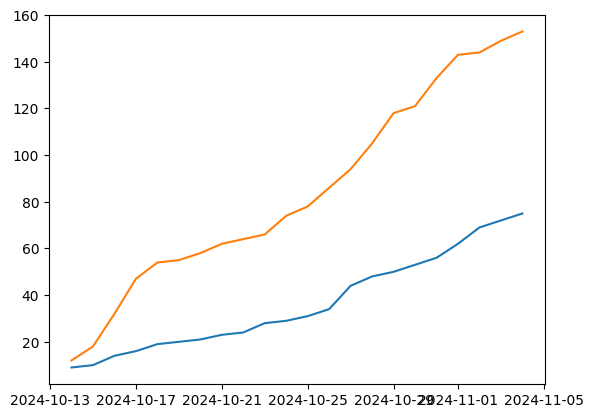

In [32]:
ax = plt.subplot()
ax.plot(positive_dates, positive_counts)
ax.plot(negative_dates, negative_counts)

In [33]:
print(df['negative/neutral/positive'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
negative/neutral/positive &  \\
\midrule
neutral & 278 \\
negative & 153 \\
positive & 75 \\
\bottomrule
\end{tabular}



In [34]:
counts_df = df.copy()
counts_df['count'] = 1
counts_df = counts_df[['topic pass 2', 'negative/neutral/positive', 'count']]
counts_df.groupby(['topic pass 2', 'negative/neutral/positive']).count()

count
topic pass 2                         negative/neutral/positive       
Domestic Policy                      negative                      20
                                     neutral                       22
                                     positive                       9
Economic and Financial Issues        negative                       7
                                     neutral                        9
                                     positive                       5
Elections and Political Strategies   negative                      27
                                     neutral                       69
                                     positive                      12
Foreign Policy and National Security negative                       1
                                     neutral                       47
                                     positive                       9
Media and Public Engagement          negative                       3
                                     neutral                       44
                                     positive                      19
Political Attack and Accusations     negative                      29
                                     neutral                       37
                                     positive                      12
Scandals and Controversies           negative                      46
                                     neutral                       28
                                     positive                       5
Social Issues                        negative                      20
                                     neutral                       22
                                     positive                       4

In [35]:
import requests
import json
url = "https://political-bias-database.p.rapidapi.com/MBFCdata"

headers = {
	"x-rapidapi-key": "c6ce10f28bmsh47220349b18f48cp1750a0jsn3f5aee38092b",
	"x-rapidapi-host": "political-bias-database.p.rapidapi.com"
}

response = requests.get(url, headers=headers)

d = response.json()

In [36]:
from urllib.parse import urlparse

domain = urlparse('http://www.example.test/foo/bar').netloc


In [37]:
news_df = pd.DataFrame(d)
news_df

,name,profile,url,bias,factual,credibility
0,New Republic – Bias and Credibility,https://mediabiasfactcheck.com/new-republic/,newrepublic.com/,left,high,high credibility
1,Accountable.US – Bias and Credibility,https://mediabiasfactcheck.com/accountable-us/,www.accountable.us/,left,mostly,medium credibility
2,News Corpse – Bias and Credibility,https://mediabiasfactcheck.com/news-corpse/,www.newscorpse.com/,left,mixed,medium credibility
3,NewsHounds – Bias and Credibility,https://mediabiasfactcheck.com/newshounds/,www.newshounds.us/,left,mixed,medium credibility
4,Occupy.com – Bias and Credibility,https://mediabiasfactcheck.com/occupy-com/,www.occupy.com,left,high,high credibility
...,...,...,...,...,...,...
5709,American Military News – Bias and Credibility,https://mediabiasfactcheck.com/american-milita...,americanmilitarynews.com,right-center,mostly,high credibility
5710,The People’s Cube – Bias and Credibility,https://mediabiasfactcheck.com/the-peoples-cube/,thepeoplescube.com/,satire,no factual reporting rating,no credibility rating available
5711,The Shovel – Bias and Credibility,https://mediabiasfactcheck.com/the-shovel/,www.theshovel.com.au/,satire,no factual reporting rating,no credibility rating available
5712,Asian News International (ANI) – Bias and Cred...,https://mediabiasfactcheck.com/asian-news-inte...,www.aninews.in,right-center,mixed,medium credibility


In [38]:
urls = df.url.map(lambda x : urlparse(x).netloc)

In [39]:
aligns = dict()
for url in urls.unique():
    matching_rows = news_df.url.str.contains(url)
    row = news_df[matching_rows]
    if not row.empty:
        bias = row['bias'].values[0]
    else:
        bias = 'N/A'
    aligns[url] = bias

In [40]:
import json
with open('../aligns_dict.json', 'w') as f:
    json.dump(aligns, f)

In [41]:
df['clean_url'] = df['url'].map(lambda x : urlparse(x).netloc)

In [42]:
df['align'] = df['clean_url'].map(lambda x: aligns[x])
valid_df = df[df['align'] != 'N/A']

In [43]:
print(valid_df['align'].value_counts(normalize=True).map(lambda x: str(round(x, 3))).to_latex())

\begin{tabular}{ll}
\toprule
 & proportion \\
align &  \\
\midrule
left & 0.235 \\
right & 0.19 \\
left-center & 0.17 \\
right-center & 0.152 \\
center & 0.132 \\
extreme-right & 0.094 \\
satire & 0.02 \\
conspiracy & 0.005 \\
pro-science & 0.003 \\
\bottomrule
\end{tabular}



In [44]:
valid_df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic pass 2,negative/neutral/positive,date,count,is_negative,is_positive,is_neutral,clean_url,align
195,Wonkette.com,Evan Hurst,Trump's Metamorphosis Into America's Hitler Is...,"Boy, JD Vance was right when he said that.",https://www.wonkette.com/p/trumps-metamorphosi...,2024-10-14T15:47:17Z,dictatorial concerns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,www.wonkette.com,left
246,Freerepublic.com,rumble.com,JD Vance HUMILIATES ABC’s Martha Raddatz on LI...,"JD Vance, once again, shows that he is an extr...",https://freerepublic.com/focus/f-chat/4270927/...,2024-10-14T16:29:17Z,"media appearances, Venezulean gangs",Foreign Policy and National Security,positive,2024-10-14,1,False,True,False,freerepublic.com,right
245,Thepinknews.com,Sophie Perry,JD Vance says women not having children due to...,JD Vance has once again talked about women’s r...,https://www.thepinknews.com/2024/10/14/jd-vanc...,2024-10-14T15:20:16Z,"parenthood, birth rates",Social Issues,negative,2024-10-14,1,True,False,False,www.thepinknews.com,left
219,The Hill,Dominick Mastrangelo,Meghan McCain: ABC’s Martha Raddatz sounded ‘c...,Conservative pundit Meghan McCain blasted Mart...,https://thehill.com/homenews/media/4932175-mcc...,2024-10-14T15:38:10Z,media appearances,Media and Public Engagement,neutral,2024-10-14,1,False,False,True,thehill.com,center
201,Politicalwire.com,Taegan Goddard,Trump Still Hasn’t Released His Tax Returns,Donald Trump was once harshly criticized for f...,https://politicalwire.com/2024/10/14/trump-sti...,2024-10-14T14:36:19Z,Trump's tax returns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,politicalwire.com,center


In [45]:
renaming = {'topic pass 2': 'topic'}
df = df.rename(columns=renaming)
clean_df = df[['source', 'author', 'title', 'description', 'url', 'publishedAt', 'topic', 'negative/neutral/positive', 'align']]
clean_df

,source,author,title,description,url,publishedAt,topic,negative/neutral/positive,align
195,Wonkette.com,Evan Hurst,Trump's Metamorphosis Into America's Hitler Is...,"Boy, JD Vance was right when he said that.",https://www.wonkette.com/p/trumps-metamorphosi...,2024-10-14T15:47:17Z,Scandals and Controversies,negative,left
246,Freerepublic.com,rumble.com,JD Vance HUMILIATES ABC’s Martha Raddatz on LI...,"JD Vance, once again, shows that he is an extr...",https://freerepublic.com/focus/f-chat/4270927/...,2024-10-14T16:29:17Z,Foreign Policy and National Security,positive,right
245,Thepinknews.com,Sophie Perry,JD Vance says women not having children due to...,JD Vance has once again talked about women’s r...,https://www.thepinknews.com/2024/10/14/jd-vanc...,2024-10-14T15:20:16Z,Social Issues,negative,left
219,The Hill,Dominick Mastrangelo,Meghan McCain: ABC’s Martha Raddatz sounded ‘c...,Conservative pundit Meghan McCain blasted Mart...,https://thehill.com/homenews/media/4932175-mcc...,2024-10-14T15:38:10Z,Media and Public Engagement,neutral,center
201,Politicalwire.com,Taegan Goddard,Trump Still Hasn’t Released His Tax Returns,Donald Trump was once harshly criticized for f...,https://politicalwire.com/2024/10/14/trump-sti...,2024-10-14T14:36:19Z,Scandals and Controversies,negative,center
...,...,...,...,...,...,...,...,...,...
14,Fox News,Greg Norman,"Trump campaign 'expanding the map,' Vance says...",Trump running mate JD Vance says the campaign ...,https://www.foxnews.com/politics/trump-campaig...,2024-11-04T12:37:46Z,Elections and Political Strategies,neutral,right
15,Slashdot.org,feedfeeder,"Man who took in Peanut, the orphaned squirrel,...","Man who took in Peanut, the orphaned squirrel,...",https://slashdot.org/firehose.pl?op=view&amp;i...,2024-11-04T15:33:18Z,Social Issues,neutral,N/A
16,TheBlaze,Cooper Williamson,JD Vance exposes how the US surveillance state...,JD Vance exposes how the US surveillance state...,https://www.theblaze.com/return/jd-vance-expos...,2024-11-04T16:06:06Z,Foreign Policy and National Security,positive,right
8,Thepinknews.com,Chantelle Billson,JD Vance mocked for saying he ‘wouldn’t be sur...,Republican vice-presidential candidate JD Vanc...,https://www.thepinknews.com/2024/11/04/rogan-j...,2024-11-04T13:53:05Z,Social Issues,negative,left


In [46]:
df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic,negative/neutral/positive,date,count,is_negative,is_positive,is_neutral,clean_url,align
195,Wonkette.com,Evan Hurst,Trump's Metamorphosis Into America's Hitler Is...,"Boy, JD Vance was right when he said that.",https://www.wonkette.com/p/trumps-metamorphosi...,2024-10-14T15:47:17Z,dictatorial concerns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,www.wonkette.com,left
246,Freerepublic.com,rumble.com,JD Vance HUMILIATES ABC’s Martha Raddatz on LI...,"JD Vance, once again, shows that he is an extr...",https://freerepublic.com/focus/f-chat/4270927/...,2024-10-14T16:29:17Z,"media appearances, Venezulean gangs",Foreign Policy and National Security,positive,2024-10-14,1,False,True,False,freerepublic.com,right
245,Thepinknews.com,Sophie Perry,JD Vance says women not having children due to...,JD Vance has once again talked about women’s r...,https://www.thepinknews.com/2024/10/14/jd-vanc...,2024-10-14T15:20:16Z,"parenthood, birth rates",Social Issues,negative,2024-10-14,1,True,False,False,www.thepinknews.com,left
219,The Hill,Dominick Mastrangelo,Meghan McCain: ABC’s Martha Raddatz sounded ‘c...,Conservative pundit Meghan McCain blasted Mart...,https://thehill.com/homenews/media/4932175-mcc...,2024-10-14T15:38:10Z,media appearances,Media and Public Engagement,neutral,2024-10-14,1,False,False,True,thehill.com,center
201,Politicalwire.com,Taegan Goddard,Trump Still Hasn’t Released His Tax Returns,Donald Trump was once harshly criticized for f...,https://politicalwire.com/2024/10/14/trump-sti...,2024-10-14T14:36:19Z,Trump's tax returns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,politicalwire.com,center


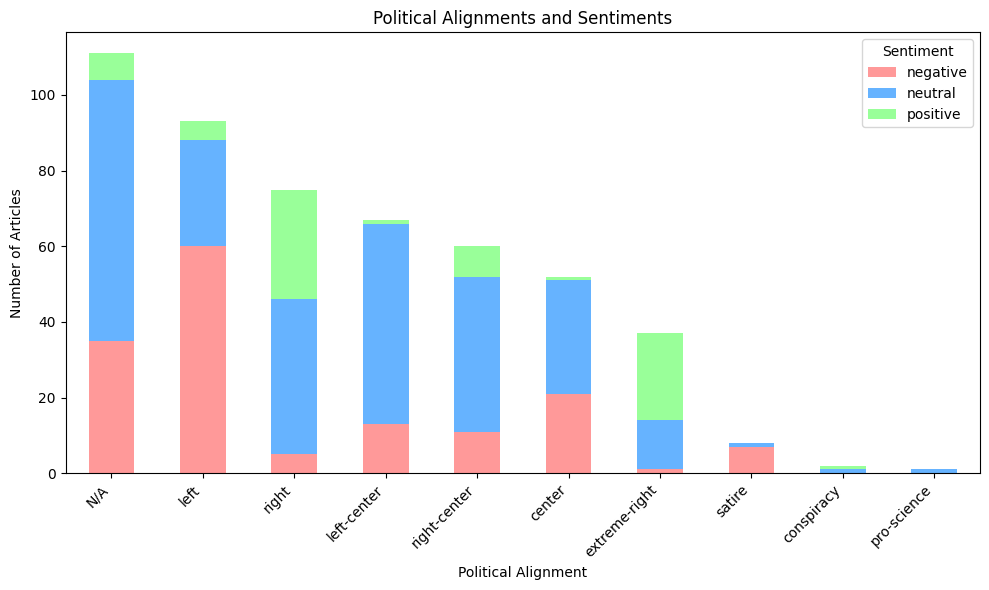

In [47]:
grouped_df = df[['align','negative/neutral/positive']].groupby(['align', 'negative/neutral/positive']).value_counts().reset_index(name='Count')
# Pivot the DataFrame
pivot_df = grouped_df.pivot(index='align', columns='negative/neutral/positive', values='Count').fillna(0)
# Compute the total count for each align and sort in descending order
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False)
pivot_df = pivot_df.drop(columns=['Total'])  # Remove the helper column
# Plot the stacked bar chart
pivot_df[['negative', 'neutral', 'positive']].plot(kind='bar', stacked=True, figsize=(10, 6),
                                                   color = ['#ff9999','#66b3ff','#99ff99'])

plt.title('Political Alignments and Sentiments')
plt.xlabel('Political Alignment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [48]:
df

,source,author,title,description,url,publishedAt,topic pass 1,topic,negative/neutral/positive,date,count,is_negative,is_positive,is_neutral,clean_url,align
195,Wonkette.com,Evan Hurst,Trump's Metamorphosis Into America's Hitler Is...,"Boy, JD Vance was right when he said that.",https://www.wonkette.com/p/trumps-metamorphosi...,2024-10-14T15:47:17Z,dictatorial concerns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,www.wonkette.com,left
246,Freerepublic.com,rumble.com,JD Vance HUMILIATES ABC’s Martha Raddatz on LI...,"JD Vance, once again, shows that he is an extr...",https://freerepublic.com/focus/f-chat/4270927/...,2024-10-14T16:29:17Z,"media appearances, Venezulean gangs",Foreign Policy and National Security,positive,2024-10-14,1,False,True,False,freerepublic.com,right
245,Thepinknews.com,Sophie Perry,JD Vance says women not having children due to...,JD Vance has once again talked about women’s r...,https://www.thepinknews.com/2024/10/14/jd-vanc...,2024-10-14T15:20:16Z,"parenthood, birth rates",Social Issues,negative,2024-10-14,1,True,False,False,www.thepinknews.com,left
219,The Hill,Dominick Mastrangelo,Meghan McCain: ABC’s Martha Raddatz sounded ‘c...,Conservative pundit Meghan McCain blasted Mart...,https://thehill.com/homenews/media/4932175-mcc...,2024-10-14T15:38:10Z,media appearances,Media and Public Engagement,neutral,2024-10-14,1,False,False,True,thehill.com,center
201,Politicalwire.com,Taegan Goddard,Trump Still Hasn’t Released His Tax Returns,Donald Trump was once harshly criticized for f...,https://politicalwire.com/2024/10/14/trump-sti...,2024-10-14T14:36:19Z,Trump's tax returns,Scandals and Controversies,negative,2024-10-14,1,True,False,False,politicalwire.com,center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,Fox News,Greg Norman,"Trump campaign 'expanding the map,' Vance says...",Trump running mate JD Vance says the campaign ...,https://www.foxnews.com/politics/trump-campaig...,2024-11-04T12:37:46Z,election predictions,Elections and Political Strategies,neutral,2024-11-04,1,False,False,True,www.foxnews.com,right
15,Slashdot.org,feedfeeder,"Man who took in Peanut, the orphaned squirrel,...","Man who took in Peanut, the orphaned squirrel,...",https://slashdot.org/firehose.pl?op=view&amp;i...,2024-11-04T15:33:18Z,Peanut,Social Issues,neutral,2024-11-04,1,False,False,True,slashdot.org,N/A
16,TheBlaze,Cooper Williamson,JD Vance exposes how the US surveillance state...,JD Vance exposes how the US surveillance state...,https://www.theblaze.com/return/jd-vance-expos...,2024-11-04T16:06:06Z,exposing Chinese spyware,Foreign Policy and National Security,positive,2024-11-04,1,False,True,False,www.theblaze.com,right
8,Thepinknews.com,Chantelle Billson,JD Vance mocked for saying he ‘wouldn’t be sur...,Republican vice-presidential candidate JD Vanc...,https://www.thepinknews.com/2024/11/04/rogan-j...,2024-11-04T13:53:05Z,"gay vote, elections, podcast",Social Issues,negative,2024-11-04,1,True,False,False,www.thepinknews.com,left


In [49]:
df['align'][df['align'] != 'N/A'].value_counts(normalize=True)

align
left             0.235443
right            0.189873
left-center      0.169620
right-center     0.151899
center           0.131646
extreme-right    0.093671
satire           0.020253
conspiracy       0.005063
pro-science      0.002532
Name: proportion, dtype: float64

In [ ]:
df['is_left'] = df['align'].map(lambda x : 'left' in x) 
df['is_right'] = df['align'].map(lambda x : 'right' in x) 
df['is_positive'] = df['negative/neutral/positive'].map(lambda x : x == 'positive') 
df['is_negative'] = df['negative/neutral/positive'].map(lambda x : x == 'negative') 
df['is_neutral'] = df['negative/neutral/positive'].map(lambda x : x == 'neutral') 

In [51]:
print(df[df['is_left']][['negative/neutral/positive']].value_counts(normalize=True).to_latex())

\begin{tabular}{lr}
\toprule
 & proportion \\
negative/neutral/positive &  \\
\midrule
neutral & 0.506250 \\
negative & 0.456250 \\
positive & 0.037500 \\
\bottomrule
\end{tabular}



In [52]:
print(df[df['is_right']][['negative/neutral/positive']].value_counts(normalize=True).to_latex())

\begin{tabular}{lr}
\toprule
 & proportion \\
negative/neutral/positive &  \\
\midrule
neutral & 0.552326 \\
positive & 0.348837 \\
negative & 0.098837 \\
\bottomrule
\end{tabular}



In [53]:
import matplotlib.pyplot as plt

def create_sentiment_pie_charts(dataframe):
    """
    Create pie charts of sentiment distribution for each unique topic
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame with 'topic pass 2' and 'negative/neutral/positive' columns
    
    Returns:
    None (displays plots)
    """
    # Get unique topics
    topics = dataframe['topic pass 2'].unique()
    topics = topics[:-1]
    
    # Calculate the number of rows and columns for subplot grid
    n_topics = len(topics)
    n_cols = 2  # Max 3 columns
    n_rows = (n_topics + n_cols - 1) // n_cols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), squeeze=False)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    colors = ['#ff9999','#66b3ff','#99ff99']
    
    # Create a pie chart for each topic
    for i, topic in enumerate(topics):
        # Filter data for the current topic
        topic_data = dataframe[dataframe['topic pass 2'] == topic]
        
        # Calculate sentiment distribution
        sentiment_counts = topic_data['negative/neutral/positive'].value_counts()
        
        # Plot pie chart
        sorted_indices = np.argsort(sentiment_counts.index.to_numpy())
        axes[i].pie(sentiment_counts[sorted_indices], labels=sentiment_counts.index[sorted_indices], 
                    autopct='%1.1f%%', startangle=90, textprops={'fontsize': 'x-large'}, colors=colors)
        axes[i].set_title(topic, fontsize='x-large')
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage
# create_sentiment_pie_charts(pnn_df)

In [62]:
df['align'].unique()

array(['left', 'right', 'center', 'right-center', 'N/A', 'left-center',
       'satire', 'extreme-right', 'pro-science', 'conspiracy'],
      dtype=object)

In [54]:
create_sentiment_pie_charts(pnn_df)

NameError: name 'pnn_df' is not defined

In [ ]:
df['topic pass 2'].map(lambda x: type(x) != str).sum()

1

In [63]:
def f(x):
    if 'left' in x:
        return 'left'
    if 'right' in x:
        return 'right'
    if 'center' in x:
        return 'center'
    else:
        return 'misc'
df['combined_align'] = df['align'].map(f)

In [76]:
misc_mask = df['combined_align'] == 'misc'

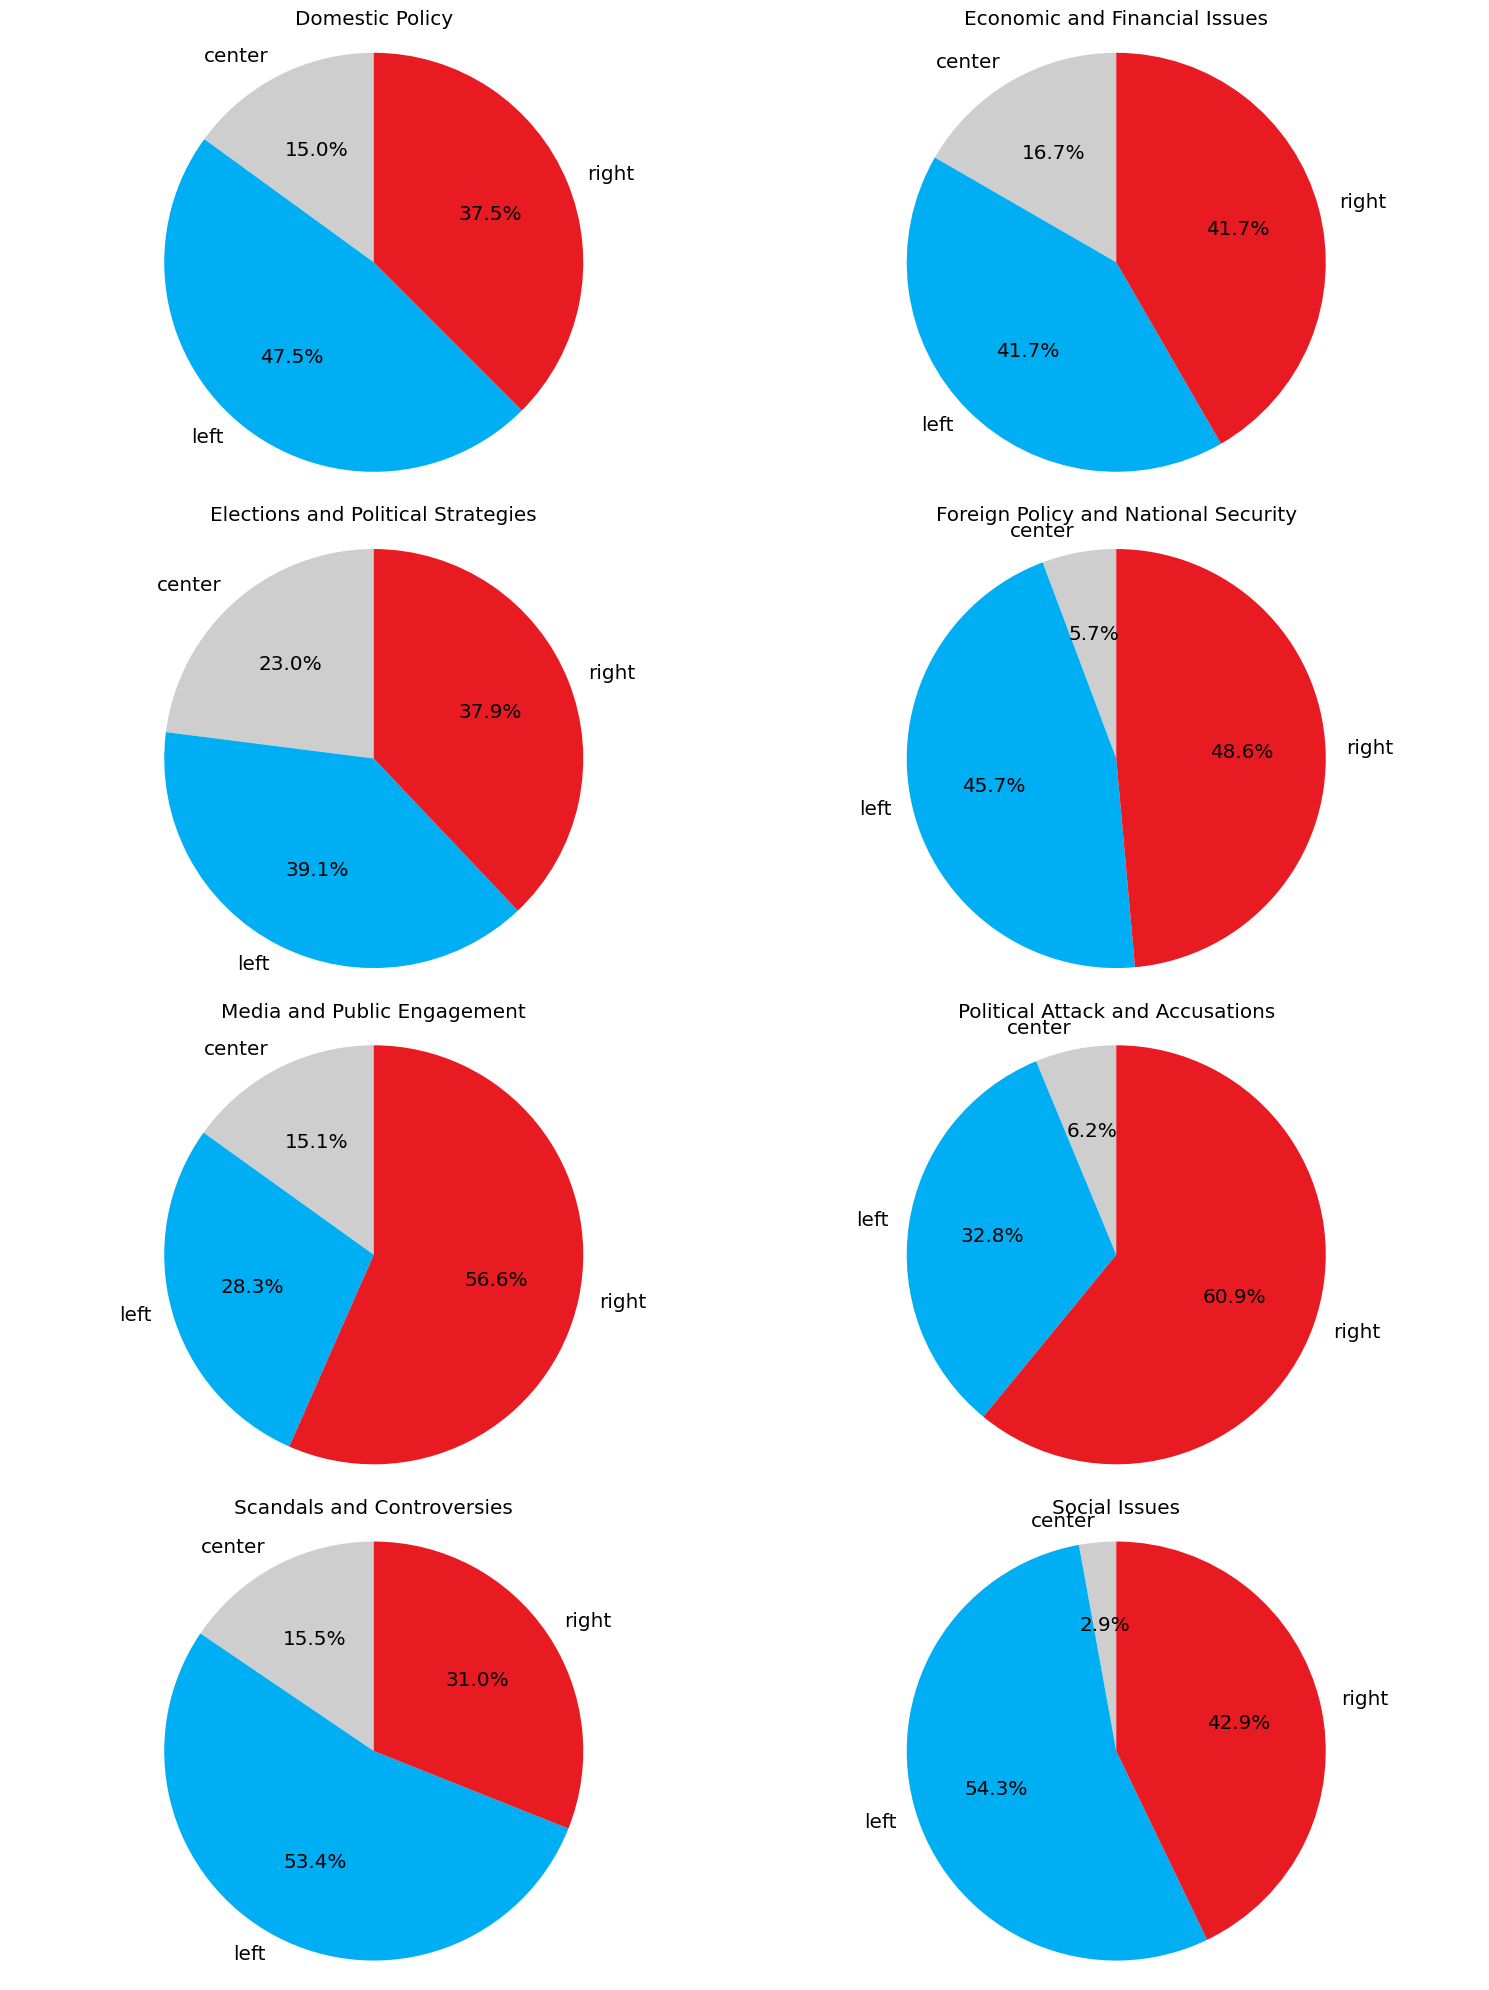

In [95]:
import matplotlib.pyplot as plt

# Normalize within each topic
counts = df[~misc_mask][['topic', 'combined_align']].groupby(['topic', 'combined_align']).size()
proportions = counts.groupby(level=0).apply(lambda x: x / x.sum())

# Iterate over topics and create a pie chart for each
topics = proportions.index.get_level_values(0).unique()

fig, ax = plt.subplots(4,2, figsize=(15,20))

for i, topic in enumerate(topics):
    # Filter data for the current topic
    r = i // 2
    c = i % 2
    topic_data = proportions.loc[topic]
    labels = topic_data.index.get_level_values(1)  # combined_align
    sizes = topic_data.values
    
    ax[r][c].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 'x-large'}, colors=['#CECECE','#00AEF3','#E81B23'])
    ax[r][c].set_title(topic, fontsize='x-large')
    ax[r][c].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

plt.tight_layout()
plt.show()